In [1]:
import torch
print(f'torch verison: {torch.__version__}')
import numpy
print(f'numpy version: {numpy.__version__}')
print(f'MPS backend: {torch.backends.mps.is_available()}')

import time

# Check device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Simple matrix multiplication test
x = torch.rand(1000, 1000).to(device)
y = torch.rand(1000, 1000).to(device)

start = time.time()
z = torch.matmul(x, y)
print(f"Matrix multiplication took {time.time() - start:.4f} seconds")

torch verison: 2.5.1
numpy version: 2.2.3
MPS backend: True
Using device: mps
Matrix multiplication took 0.4142 seconds


In [2]:
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 0,  9,  3,  1,  7,  5,  2,  4, 10]), tensor([8, 6]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [6]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[-4.1870],
        [-2.9747]], grad_fn=<AddmmBackward0>)

In [7]:
linear_model.weight

Parameter containing:
tensor([[-0.8361]], requires_grad=True)

In [8]:
linear_model.bias

Parameter containing:
tensor([-0.1404], requires_grad=True)

In [9]:
x = torch.ones(1)
linear_model(x)

tensor([-0.9765], grad_fn=<ViewBackward0>)

In [10]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.9765],
        [-0.9765],
        [-0.9765],
        [-0.9765],
        [-0.9765],
        [-0.9765],
        [-0.9765],
        [-0.9765],
        [-0.9765],
        [-0.9765]], grad_fn=<AddmmBackward0>)

In [11]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [12]:
linear_model.parameters()

<generator object Module.parameters at 0x1067090e0>

In [13]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.7547]], requires_grad=True),
 Parameter containing:
 tensor([-0.5480], requires_grad=True)]

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 192.9979, Validation loss 15.7485
Epoch 1000, Training loss 3.2651, Validation loss 5.7529
Epoch 2000, Training loss 2.2888, Validation loss 5.8789
Epoch 3000, Training loss 2.2529, Validation loss 6.0933

Parameter containing:
tensor([[5.4577]], requires_grad=True)
Parameter containing:
tensor([-17.7187], requires_grad=True)


In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.2254], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 229.7537, Validation loss 25.4545
Epoch 1000, Training loss 4.5283, Validation loss 7.1467
Epoch 2000, Training loss 4.1497, Validation loss 5.1114
Epoch 3000, Training loss 2.2578, Validation loss 4.3690
Epoch 4000, Training loss 1.6021, Validation loss 4.3186
Epoch 5000, Training loss 1.4461, Validation loss 4.5487
output tensor([[7.5337],
        [0.3931]], grad_fn=<AddmmBackward0>)
answer tensor([[6.],
        [3.]])
hidden tensor([[-0.9673],
        [-0.7323],
        [ 2.9559],
        [ 0.8488],
        [ 0.0126],
        [ 3.0679],
        [-1.9718],
        [ 2.4817]])


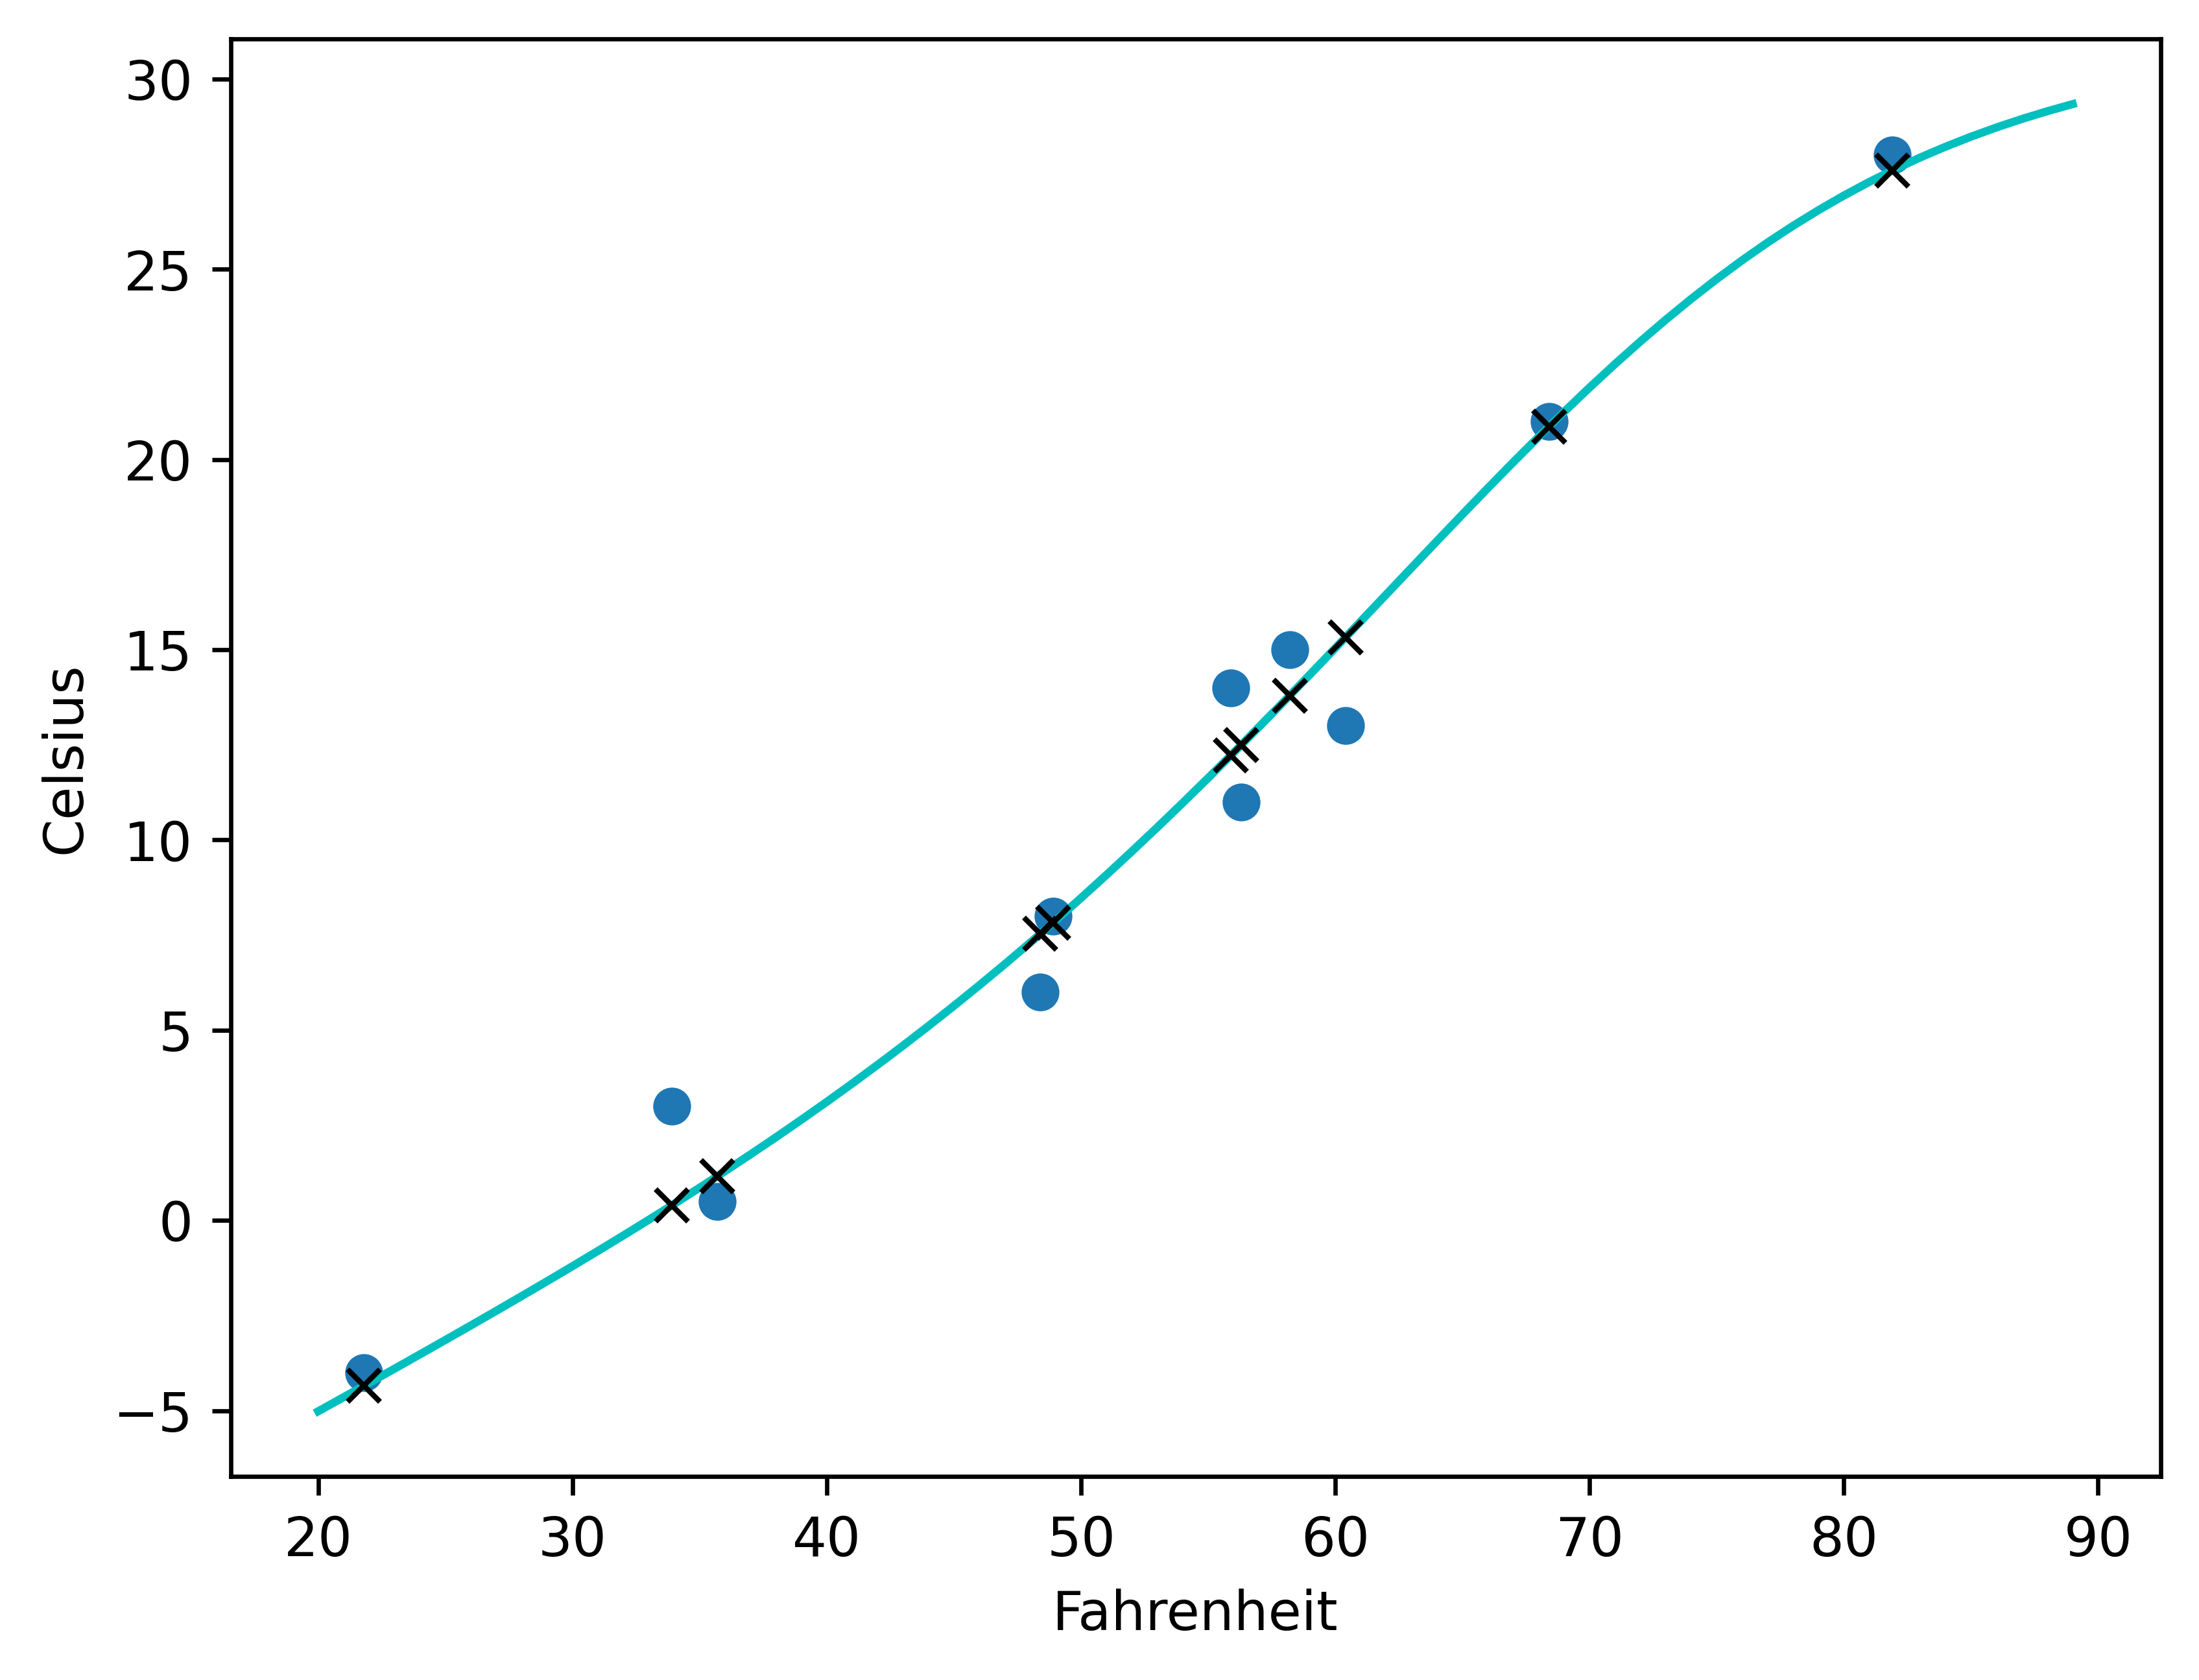

In [23]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
